# **Sentiment Analysis on Respondent Perceptions on Café Business (Thailand)**

The Effect of Marketing Experience on Customer Loyalty in Thai Café Businesses: A Comparative Analysis of SMEs and Large Chains
Chananchida Siriouychai 2641729

In [ ]:
#Import Libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud

#Load the dataset
df = pd.read_excel("comments_sentiment2.xlsx")

# **Data Preprocessing**

In [ ]:
#drop missing values
df = df.dropna(subset=["Comments"]).copy()
df["Labels"] = df["Labels"].str.strip().str.capitalize()
df = df[df["Labels"].isin(["Positive", "Negative"])].copy()

#custom stop words
custom_stop = set(ENGLISH_STOP_WORDS) | {"coffee","shop","café","place","drink", "isnt", "t"}
def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"[^a-z\s]", " ", s)
    toks = [w for w in s.split() if w not in custom_stop]
    return " ".join(toks)

df["Cleaned"] = df["Comments"].apply(clean_text)


# **SMOTE (Synthetic Minority Oversampling Technique) for Imbalanced Classification**

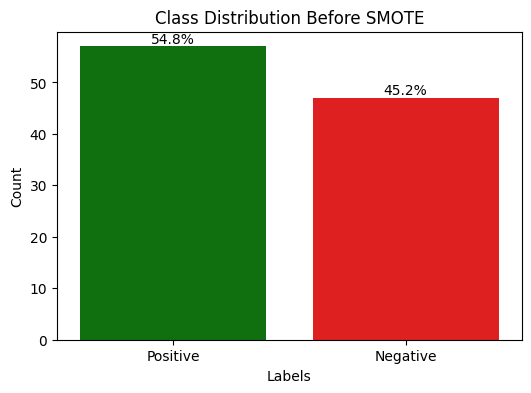

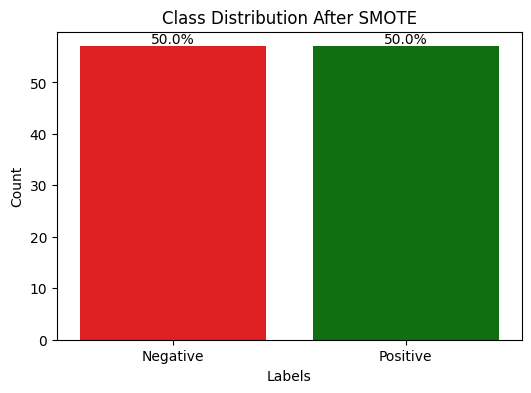

In [ ]:
# Train/Test split
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df["Cleaned"], df["Labels"], test_size=0.2, stratify=df["Labels"], random_state=42
)

# Class distribution before SMOTE
plt.figure(figsize=(6, 4))
ax_before = sns.countplot(x=y_train, order=y_train.value_counts().index, palette={'Positive': 'green', 'Negative': 'red'}, hue=y_train, legend=False)
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Labels')
plt.ylabel('Count')
total_before = len(y_train)
for p in ax_before.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total_before)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax_before.annotate(percentage, (x, y), ha='center', va='bottom')
plt.show()

# Apply SMOTE
tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train_text)
oversample = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = oversample.fit_resample(X_train_tfidf, y_train)


# Class distribution after SMOTE
plt.figure(figsize=(6, 4))
ax_after = sns.countplot(x=y_train_balanced, order=y_train_balanced.value_counts().index, palette={'Positive': 'green', 'Negative': 'red'}, hue=y_train_balanced, legend=False)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Labels')
plt.ylabel('Count')
total_after = len(y_train_balanced)
for p in ax_after.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total_after)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax_after.annotate(percentage, (x, y), ha='center', va='bottom')
plt.show()

# **Cross Validation of Models: Logistic Resression/ SVM/ RF**


=== Cross-Validated Model Comparison (means over 5 folds) ===
              Model  Accuracy  Macro F1  Macro Precision  Macro Recall
Logistic Regression  0.846154  0.837816         0.875645      0.837381
         Linear SVM  0.823077  0.816292         0.846943      0.816147
      Random Forest  0.815385  0.803032         0.852026      0.805238

=== Held-out Test Evaluation (Logistic Regression) ===
[[ 9  3]
 [ 1 13]]
              precision    recall  f1-score   support

    Negative      0.900     0.750     0.818        12
    Positive      0.812     0.929     0.867        14

    accuracy                          0.846        26
   macro avg      0.856     0.839     0.842        26
weighted avg      0.853     0.846     0.844        26



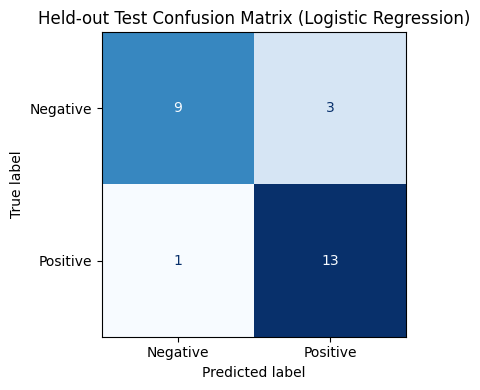

In [ ]:
# Cross-validated model comparison
X_all, y_all = df["Cleaned"].values, df["Labels"].values
tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))
oversample = SMOTE(random_state=42)


# Train/Test split
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df["Cleaned"], df["Labels"], test_size=0.2, stratify=df["Labels"], random_state=42
)

models = {
    "Logistic Regression": LogisticRegression(max_iter=200, random_state=42),
    "Linear SVM": LinearSVC(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=400, random_state=42),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "acc": "accuracy",
    "f1_macro": "f1_macro",
    "prec_macro": "precision_macro",
    "rec_macro": "recall_macro",
}

rows = []
for name, clf in models.items():
    pipe = Pipeline([("tfidf", tfidf), ("oversample", oversample), ("clf", clf)])
    scores = cross_validate(pipe, X_all, y_all, cv=cv, scoring=scoring, n_jobs=-1)
    rows.append({
        "Model": name,
        "Accuracy": np.mean(scores["test_acc"]),
        "Macro F1": np.mean(scores["test_f1_macro"]),
        "Macro Precision": np.mean(scores["test_prec_macro"]),
        "Macro Recall": np.mean(scores["test_rec_macro"]),
    })

res_df = pd.DataFrame(rows).sort_values(["Macro F1","Accuracy"], ascending=False)
print("\n=== Cross-Validated Model Comparison (means over 5 folds) ===")
print(res_df.to_string(index=False))

# Train best model on train split
best_name = res_df.iloc[0]["Model"]
best_clf = models[best_name]

best_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=2000, ngram_range=(1, 2))),
    ("oversample", SMOTE(random_state=42)),
    ("clf", best_clf)
])

best_pipe.fit(X_train_text, y_train)
y_pred = best_pipe.predict(X_test_text)

print(f"\n=== Held-out Test Evaluation ({best_name}) ===")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=best_pipe.named_steps["clf"].classes_)
fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title(f"Held-out Test Confusion Matrix ({best_name})")
plt.tight_layout()
plt.show()

# **Words Clouds** Positive vs. Negative Sentiments

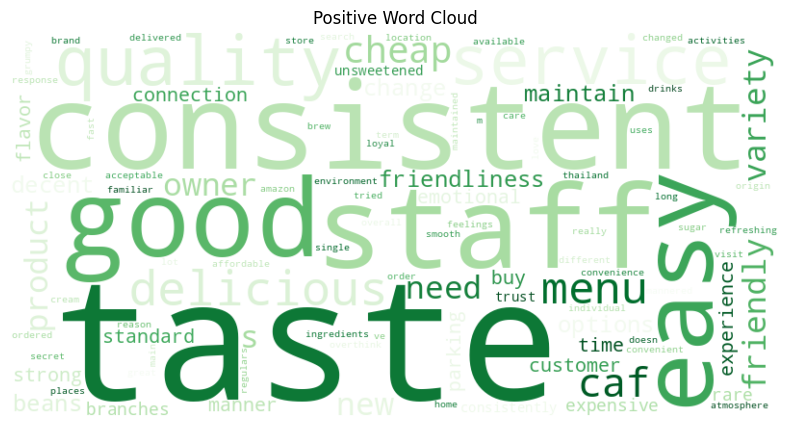

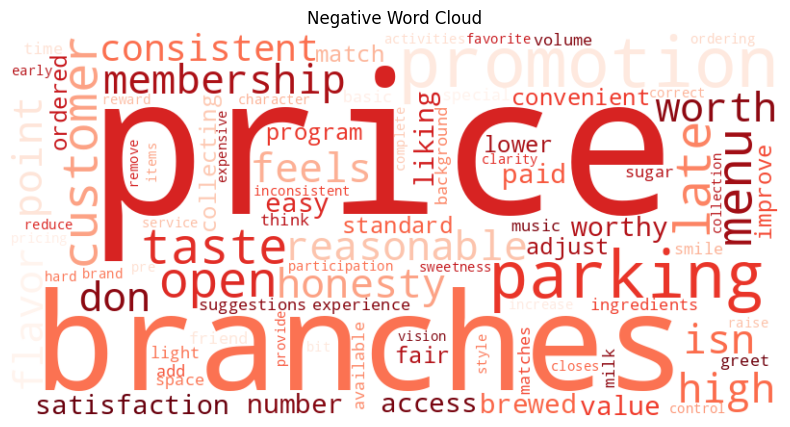

In [ ]:
#word-cloud
pos_text = " ".join(df.loc[df["Labels"]=="Positive","Cleaned"])
neg_text = " ".join(df.loc[df["Labels"]=="Negative","Cleaned"])

wc_pos = WordCloud(width=800, height=400, background_color="white", colormap="Greens", max_words=100).generate(pos_text)
wc_neg = WordCloud(width=800, height=400, background_color="white", colormap="Reds",   max_words=100).generate(neg_text)

plt.figure(figsize=(10,5)); plt.imshow(wc_pos, interpolation="bilinear"); plt.axis("off"); plt.title("Positive Word Cloud"); plt.show()
plt.figure(figsize=(10,5)); plt.imshow(wc_neg, interpolation="bilinear"); plt.axis("off"); plt.title("Negative Word Cloud"); plt.show()


def clean_for_model(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    toks = [w for w in text.split() if w not in custom_stop]
    return " ".join(toks)

df["Cleaned_Comments"] = df["Comments"].apply(clean_for_model)

# **Top Words by Sentiment**

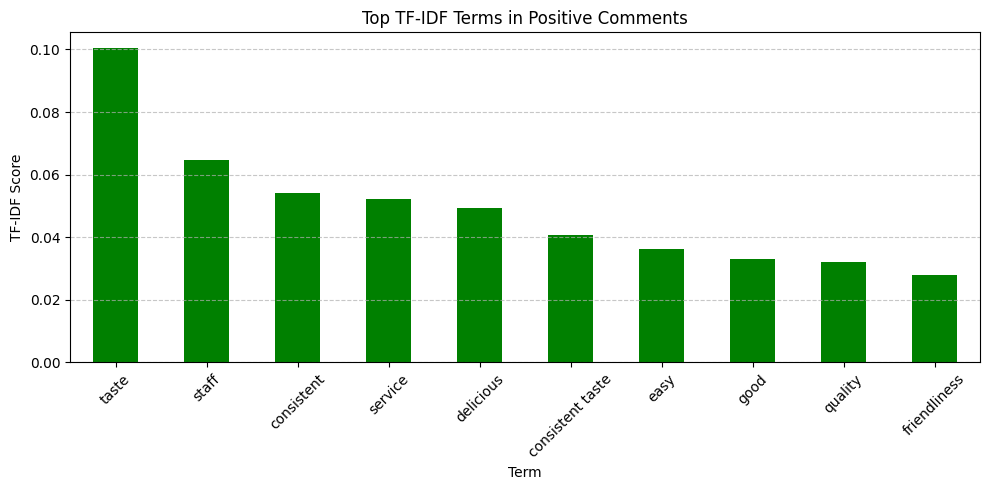

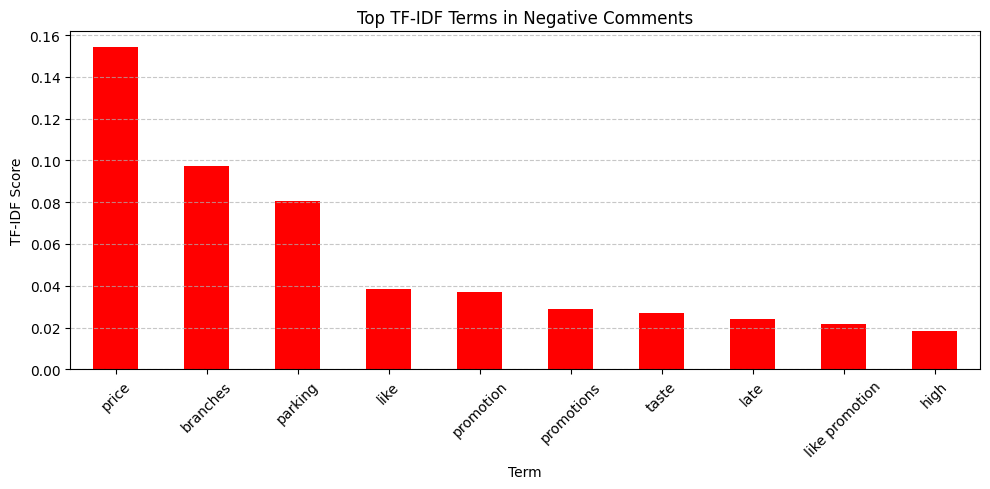

In [ ]:
# Get top words by sentiment
# Create tfidf_df
tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))
tfidf_matrix = tfidf.fit_transform(df["Cleaned"])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df["Sentiment"] = df["Labels"].values

tfidf_mean = tfidf_df.groupby("Sentiment").mean().T
top_pos = tfidf_mean["Positive"].sort_values(ascending=False).head(10)
top_neg = tfidf_mean["Negative"].sort_values(ascending=False).head(10)


# Plot TF-IDF Bar Chart: Positive
plt.figure(figsize=(10, 5))
top_pos.plot(kind='bar', color='green')
plt.title("Top TF-IDF Terms in Positive Comments")
plt.ylabel("TF-IDF Score")
plt.xlabel("Term")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot TF-IDF Bar Chart: Negative
plt.figure(figsize=(10, 5))
top_neg.plot(kind='bar', color='red')
plt.title("Top TF-IDF Terms in Negative Comments")
plt.ylabel("TF-IDF Score")
plt.xlabel("Term")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Export the cross-validated model comparison results to an Excel file
res_df.to_excel("cross_validated_model_comparison.xlsx", index=False)

print("Cross-validated model comparison results exported to cross_validated_model_comparison.xlsx")

Cross-validated model comparison results exported to cross_validated_model_comparison.xlsx
